In [1]:
import cv2
import matplotlib.pyplot as plt
from nltk import edit_distance
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import trange

## Класс данных

In [2]:
class OcrDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, dictionary, train=True, size=(128, 32), transform=None):
        self.data_dir = os.path.join(data_dir, 'train' if train else 'test')
        self.dictionary = dictionary
        self.size = size
        self.transform = transform
        self.image_paths = [os.path.join(self.data_dir, name) for name in os.listdir(self.data_dir)]
        
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.resize(image, self.size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        label = self.image_paths[idx].split('-')[-1].split('.')[0]
        label = torch.LongTensor([self.dictionary[ch] for ch in label])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


## Модель

In [3]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.fcnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(2, 1), padding=(0, 1)),
            
            nn.Conv2d(512, 1024, kernel_size=2, padding=0), 
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )
        self.bilstm = nn.LSTM(input_size=1024, hidden_size=512, num_layers=2, bidirectional=True)
        self.decoder = nn.Linear(2 * 512, self.num_classes)

    def forward(self, x):
        x = self.fcnn(x)
        x = x.squeeze(2).permute(2, 0, 1)
        x, _ = self.bilstm(x)
        seq_len, batch_size, _ = x.size()
        x = self.decoder(x)
        x = x.view(seq_len, batch_size, self.num_classes)
        return x

## Обучение модели

In [4]:
BATCH_SIZE = 256
NUM_EPOCHS = 10
MODEL_PATH = '/kaggle/working/model.pth'
DATA_DIR = '/kaggle/input/ccpd2019/CCPD2019-dl1'
CHARS = ['-', '皖', '沪', '津', '渝', '冀', '晋', '蒙', '辽', '吉', '黑', '苏', '浙', '京', '闽', 
         '赣', '鲁', '豫', '鄂', '湘', '粤', '桂', '琼', '川', '贵', '云', '藏', '陕', '甘', '青', 
         '宁', '新', '警', '学', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 
         'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', 
         '5', '6', '7', '8', '9']
CHARS_DICT = {ch: i for i, ch in enumerate(CHARS)}
NUM_CLASSES = len(CHARS)
TOP_K_IMAGES = 30
TEST_SAMPLES = 9999

In [5]:
# Преобразования данных с аугментацией
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomPerspective(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = OcrDataset(data_dir=DATA_DIR, dictionary=CHARS_DICT, train=True, transform=train_transform)
test_dataset = OcrDataset(data_dir=DATA_DIR, dictionary=CHARS_DICT, train=False, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CRNN(num_classes=NUM_CLASSES)
model = model.to(device)
criterion = nn.CTCLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in trange(NUM_EPOCHS):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        log_probs = F.log_softmax(logits, dim=-1)
        
        T, N, _ = log_probs.size()
        input_len = torch.LongTensor([T for _ in range(N)])
        target_len = torch.LongTensor([labels.size(-1) for _ in range(N)])
        loss = criterion(log_probs, labels, input_len, target_len)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f'Epoch: {epoch}, i: {i}, loss: {loss:.3f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, i: 0, loss: 7.758
Epoch: 0, i: 50, loss: 2.548
Epoch: 0, i: 100, loss: 2.259
Epoch: 0, i: 150, loss: 1.213
Epoch: 0, i: 200, loss: 0.453
Epoch: 0, i: 250, loss: 0.240
Epoch: 0, i: 300, loss: 0.193
Epoch: 0, i: 350, loss: 0.184
Epoch: 0, i: 400, loss: 0.127
Epoch: 0, i: 450, loss: 0.126
Epoch: 0, i: 500, loss: 0.131
Epoch: 0, i: 550, loss: 0.134
Epoch: 0, i: 600, loss: 0.109
Epoch: 0, i: 650, loss: 0.071
Epoch: 0, i: 700, loss: 0.062
Epoch: 0, i: 750, loss: 0.106
Epoch: 1, i: 0, loss: 0.099
Epoch: 1, i: 50, loss: 0.096
Epoch: 1, i: 100, loss: 0.089
Epoch: 1, i: 150, loss: 0.074
Epoch: 1, i: 200, loss: 0.083
Epoch: 1, i: 250, loss: 0.055
Epoch: 1, i: 300, loss: 0.061
Epoch: 1, i: 350, loss: 0.071
Epoch: 1, i: 400, loss: 0.047
Epoch: 1, i: 450, loss: 0.049
Epoch: 1, i: 500, loss: 0.067
Epoch: 1, i: 550, loss: 0.071
Epoch: 1, i: 600, loss: 0.063
Epoch: 1, i: 650, loss: 0.042
Epoch: 1, i: 700, loss: 0.045
Epoch: 1, i: 750, loss: 0.070
Epoch: 2, i: 0, loss: 0.042
Epoch: 2, i: 50, l

In [6]:
torch.save(model.state_dict(), MODEL_PATH)

## Тестирование модели и подсчет метрик

In [7]:
def get_label(predicted):
    label = ""
    for i in range(len(predicted)):
        if predicted[i] != 0 and not (i > 0 and predicted[i] == predicted[i - 1]):
            label += CHARS[predicted[i]]
    return label

In [18]:
total_edit_distance = 0
total_len = 0
error_images = []

model = CRNN(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
with torch.no_grad(): 
    for image, label in test_loader: 
        image = image
        logits = model(image)
        log_probs = F.log_softmax(logits, dim=-1)
        predicted = log_probs.argmax(-1).transpose(1, 0)[0]
        pred_label = get_label(predicted)
        label = ''.join([CHARS[i] for i in label[0]])
        edit_dist = edit_distance(pred_label, label)
        label_len = max(len(label), len(pred_label))
        if edit_dist > 0:
            error_images.append((image, label, pred_label, edit_dist / label_len))
        total_edit_distance += edit_dist
        total_len += label_len

In [65]:
print(f'Accuracy: {(TEST_SAMPLES - len(error_images)) / TEST_SAMPLES:.4f}, \
      CER: {total_edit_distance / total_len:.4f}')

Accuracy: 0.9752,       CER: 0.0041


## Анализ ошибок моделей

Real label: 皖AMQ059, predicted label: 京M88E9, CER: 0.714


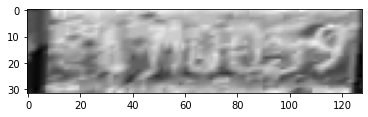

Real label: 皖AG511F, predicted label: 苏AG517E, CER: 0.429


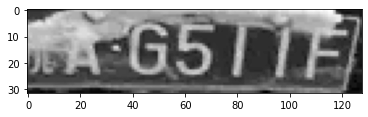

Real label: 皖Q99066, predicted label: 鲁QQQ066, CER: 0.429


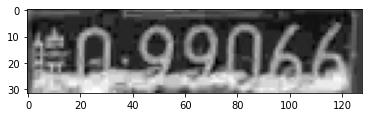

Real label: 皖A188V0, predicted label: 皖AX888, CER: 0.429


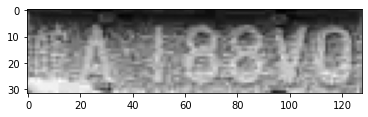

Real label: 皖AK927W, predicted label: 皖AK999, CER: 0.429


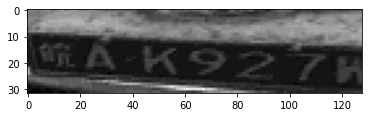

Real label: 渝F77X15, predicted label: 渝FZZX5, CER: 0.429


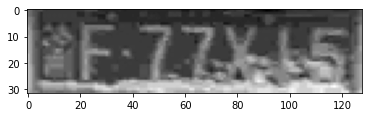

Real label: 皖AD6Z16, predicted label: 鲁A06Z16, CER: 0.286


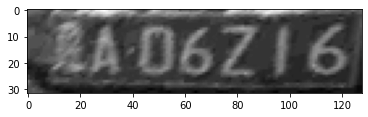

Real label: 赣E6V671, predicted label: 赣E6W67T, CER: 0.286


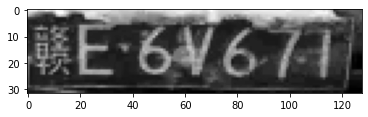

Real label: 皖A03327, predicted label: 皖AB332T, CER: 0.286


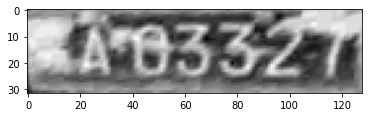

Real label: 皖ANY833, predicted label: 皖ANY463, CER: 0.286


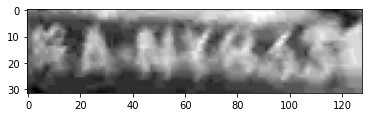

Real label: 皖AH309S, predicted label: 皖AH300C, CER: 0.286


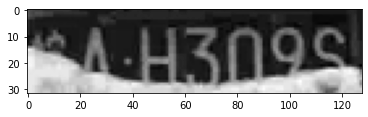

Real label: 皖AP211M, predicted label: 皖AF217M, CER: 0.286


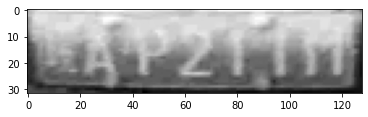

Real label: 云A3151H, predicted label: 皖A315TH, CER: 0.286


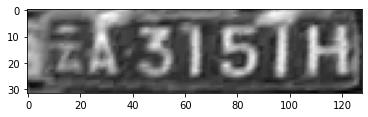

Real label: 皖A771X8, predicted label: 浙771X8, CER: 0.286


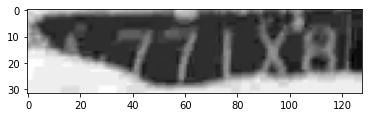

Real label: 皖AZ861H, predicted label: 粤AZ867H, CER: 0.286


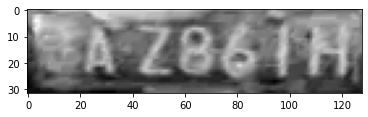

Real label: 皖AJ1669, predicted label: 皖AM669, CER: 0.286


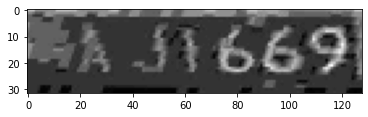

Real label: 皖AJ915C, predicted label: 皖A89156, CER: 0.286


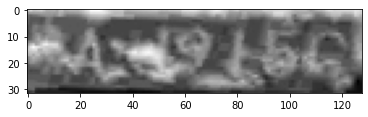

Real label: 苏FA8A15, predicted label: 苏FX8AT5, CER: 0.286


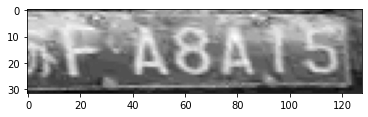

Real label: 皖AGS308, predicted label: 皖AGS38B, CER: 0.286


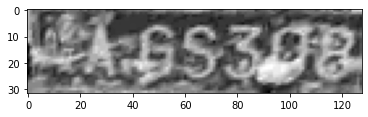

Real label: 皖E97765, predicted label: 冀E07765, CER: 0.286


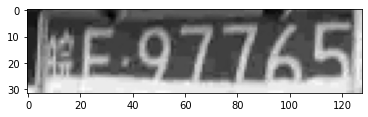

Real label: 皖AX7M75, predicted label: 皖AX7M98, CER: 0.286


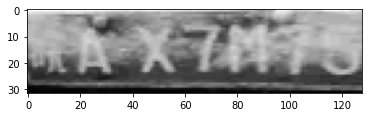

Real label: 鲁M712V1, predicted label: 浙MZ12V1, CER: 0.286


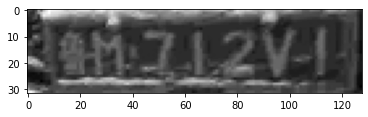

Real label: 皖A06383, predicted label: 皖D6383, CER: 0.286


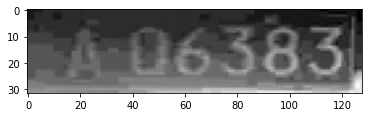

Real label: 皖ANZ538, predicted label: 皖AMZ588, CER: 0.286


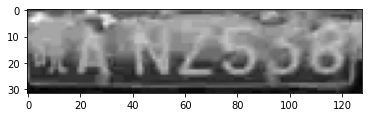

Real label: 皖AE1307, predicted label: 皖AET30F, CER: 0.286


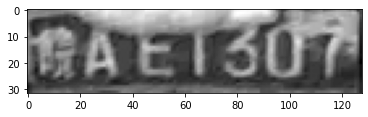

Real label: 吉BTW976, predicted label: 晋BTW946, CER: 0.286


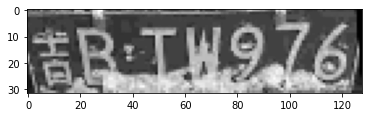

Real label: 皖AX7J16, predicted label: 皖AX73T6, CER: 0.286


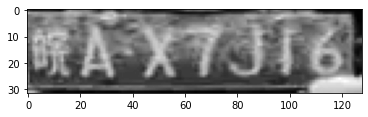

Real label: 皖AWR768, predicted label: 皖AWB762, CER: 0.286


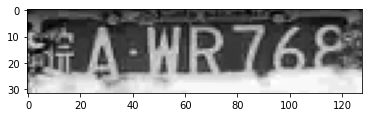

Real label: 皖A5R551, predicted label: 皖A8R581, CER: 0.286


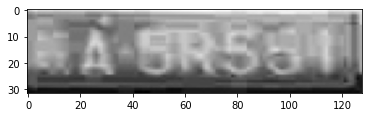

Real label: 苏BE767W, predicted label: 冀DE767W, CER: 0.286


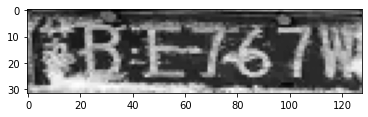

In [69]:
error_images = sorted(error_images, key=lambda tup: tup[3], reverse=True)
samples = TOP_K_IMAGES if TOP_K_IMAGES <= len(error_images) else len(error_images)
for i in range(samples):
    image, label, pred_label, cer = error_images[i]
    print(f'Real label: {label}, predicted label: {pred_label}, CER: {cer:.3f}')
    plt.imshow(image[0, 0], cmap='gray')
    plt.show()

Модель чаще всего ошибается на номерах, часть которых перекрыта, либо размыта, а также в иероглифах. Попытаться повысить качество можно путем увеличения тренировочной выборки и использования более продвинутой аугментации (различная обрезка изображения и внесение помех).